# Measure invariance to rotations in a custom CNN

Using PyTorch, we will define a custom CNN, train it with MNIST, and afterwards measure its invariance with respect to rotations on that dataset.


First, we install the `tmeasures` library, as well as other `poutyne` to simplify training and `scikit-learn` for some goodies.

We also define the compute device and the path to store data and results.

In [1]:
!pip install tmeasures poutyne scikit-learn
%load_ext autoreload
%autoreload 2
import torch 
from pathlib import Path

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_path = Path("~/tm_example_pytorch/").expanduser()
results_path.mkdir(parents=True, exist_ok=True)

You should consider upgrading via the '/home/facundoq/.virtualenvs/tm/bin/python -m pip install --upgrade pip' command.


/home/facundoq/.virtualenvs/tm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define a vanilla PyTorch CNN model

In this case we will define simple model with 2 blocks of Conv2D-ReLU-MaxPool2D and then two linear layers.


In [2]:
from torch import nn


class Flatten(nn.Module):
    def forward(self, input: torch.Tensor):
        return input.view(input.size(0), -1)

# Model definition
class CNN(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        c, h, w = shape
        h_flat, w_flat = h // 4, w // 4
        filters = 32
        filters2 = filters * 2
        flat = h_flat * w_flat * filters2
        self.model = nn.Sequential(
            nn.Conv2d(c, filters, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(filters, filters2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Flatten(),
            nn.Linear(flat, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=-1),
        )

    # forward works as normal
    def forward(self, x):
        return self.model.forward(x)


# Train model with MNIST and rotation transformations for data augmentation

Use the `torchvision` class MNIST to download and perform data augmentation on the samples of MNIST, both for training and testing sets. Then use `pouytine` to train the model.

You can modify the variable `degree_range` to increase or decreaes the strength of the transformations, and hence of the invariance obtained by the model while training.

In [3]:
from torchvision import transforms, datasets
from poutyne import Model

base_preprocessing = [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]
# Rotation data augmentation
# CHANGE THIS VARIABLE from 0 to 180 to train with different intensities of data augmentation
# More data augmentation will cause the network to be more invariant
degree_range = 180  # train with random rotations from -degree_range to degree_range
train_augmentation = [transforms.RandomRotation(degree_range)]
train_transform = transforms.Compose(train_augmentation + base_preprocessing)
measure_transform = transforms.Compose(base_preprocessing)
path = results_path / 'mnist'

train_dataset = datasets.MNIST(path, train=True, download=True,
                                transform=train_transform)
test_dataset = datasets.MNIST(path, train=False,
                              transform=train_transform)


# TRAIN

model = CNN((1, 28, 28))
poutyne_model = Model(model,
                      optimizer='adam',
                      loss_function='cross_entropy',
                      batch_metrics=['accuracy'],
                      device=device)
poutyne_model.fit_dataset(train_dataset, test_dataset, epochs=10, batch_size=128,num_workers=2  ,dataloader_kwargs={"pin_memory":True})



Epoch:  1/10 Train steps: 469 Val steps: 79 7.54s loss: 0.663386 acc: 78.416667 val_loss: 0.340627 val_acc: 89.200000
Epoch:  2/10 Train steps: 469 Val steps: 79 7.36s loss: 0.268210 acc: 91.701667 val_loss: 0.206304 val_acc: 93.430000
Epoch:  3/10 Train steps: 469 Val steps: 79 7.40s loss: 0.197777 acc: 93.865000 val_loss: 0.168976 val_acc: 94.780000
Epoch:  4/10 Train steps: 469 Val steps: 79 7.51s loss: 0.165179 acc: 94.885000 val_loss: 0.156209 val_acc: 95.260000
Epoch:  5/10 Train steps: 469 Val steps: 79 9.18s loss: 0.144342 acc: 95.441667 val_loss: 0.131536 val_acc: 95.990000
Epoch:  6/10 Train steps: 469 Val steps: 79 9.47s loss: 0.130995 acc: 95.805000 val_loss: 0.115833 val_acc: 96.120000
Epoch:  7/10 Train steps: 469 Val steps: 79 9.08s loss: 0.119562 acc: 96.291667 val_loss: 0.114653 val_acc: 96.310000
Epoch:  8/10 Train steps: 469 Val steps: 79 10.18s loss: 0.111542 acc: 96.570000 val_loss: 0.114183 val_acc: 96.310000
Epoch:  9/10 Train steps: 469 Val steps: 79 10.31s loss

[{'epoch': 1,
  'time': 7.543540852999286,
  'loss': 0.6633862086455027,
  'acc': 78.41666667480469,
  'val_loss': 0.3406267374038696,
  'val_acc': 89.2},
 {'epoch': 2,
  'time': 7.363233784999466,
  'loss': 0.26821009095509846,
  'acc': 91.70166665852865,
  'val_loss': 0.2063039723277092,
  'val_acc': 93.43},
 {'epoch': 3,
  'time': 7.404440263000652,
  'loss': 0.1977768410841624,
  'acc': 93.865,
  'val_loss': 0.16897573563456536,
  'val_acc': 94.78},
 {'epoch': 4,
  'time': 7.509549147000143,
  'loss': 0.16517858513593675,
  'acc': 94.885,
  'val_loss': 0.15620922868847847,
  'val_acc': 95.26},
 {'epoch': 5,
  'time': 9.178369919000033,
  'loss': 0.1443424388964971,
  'acc': 95.44166665852865,
  'val_loss': 0.1315355174690485,
  'val_acc': 95.99},
 {'epoch': 6,
  'time': 9.471895355000015,
  'loss': 0.13099518531958262,
  'acc': 95.805,
  'val_loss': 0.11583285233974457,
  'val_acc': 96.12},
 {'epoch': 7,
  'time': 9.082001443999616,
  'loss': 0.11956216707229614,
  'acc': 96.291666

# Measure model's invariance  to rotations

To measure the model's invariance, we require three things:

1. A version of the dataset, without labels and reduced in size to reduce computation.
2. A discrete and finite set of transformations 
3. The model itself, with access to intermediate values or activations

Afterwards, we can create an Invariance Measure and compute it with these elements.

# 1. Dataset

Since the invariance measure do not use the labels of the dataset, we will create a custom MNIST dataset which does not return labels, only samples.

Also, since the invariance measure does not require large sample sizes, we will subsample the test set of mnist to obtain a reduced sample and reduce computation time.



In [4]:
class MNIST(datasets.MNIST):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return x
dataset_nolabels = MNIST(path, train=False, download=True, transform=measure_transform)


# Subsample 
N = 1000
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices, _ = train_test_split(np.arange(len(dataset_nolabels)), train_size=N, stratify=dataset_nolabels.targets,random_state=0)
dataset_nolabels = Subset(dataset_nolabels, indices)



# 2. Transformations

While `torchvision.transforms` provides ready-made transformations, in this case we will have to roll our own, since we have to define a finite set of transformations. Luckily, `tmeasures` has already define some sets of transformations for us, including rotations. In this case, we are using `n=128` transformations, with angles sampled uniformly from `0.0` (0º) to `1.0` (360º).

In [5]:

# Create a set of rotation transformations
from tmeasures.transformations.parameters import UniformRotation
from tmeasures.pytorch.transformations.affine import AffineGenerator

rotation_parameters = UniformRotation(n=128, angles=1.0)
transformations = AffineGenerator(r=rotation_parameters)

# 3. Model

PyTorch works with `nn.Module` objects that provide a `forward` method. The invariance measures, however, requiere not just the result(s) of the `forward` method but the result of the intermediate values or activations used to compute the final output(s). 

While it would be possible to modify a `nn.Module` defined model to return all of its activations, this would be cumbersome and difficult to manage since when training/testing we would require the *usual* `forward`, and when computing the measure we would require the new `forward`.

Therefore, measures in `tmeasures` require a model that implements the `ActivationsModule` interface with just two methods: `forward_activations` and `activation_names`. While implementing these methods allow you to best decide which activations are selected and how they are used, they can be cumbersome to define and mantain, specially when actively modifying a model.

Luckily, the `AutoActivationsModule` can take an unmodified `nn.Module` and automatically implement these methods using [forward hooks](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html).



In [6]:
import tmeasures as tm

# Put the model in evaluation mode
model.eval()

# Create an ActivationsModule from the vanilla model
activations_module = tm.pytorch.AutoActivationsModule(model)


# Computing the measure

Last step before computing the measure: we need to define a PyTorchMeasureOptions object to configure where and the measure will be computed. The `batch_size` and `num_workers` keywords are analogous to the ones used in [PyTorch's DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

The `data_device`, `model_device` and `measure_device`   indicate, respectively, where the transformations and data preprocessing is performed, where the activations of the model are computed, and finally where the actual measure is computed. In simple cases, these devices could all be the same.

Finally, we can `eval` the measure with the dataset, transformation, model and options, obtaining a `PyTorchMeasureResult`, which can be handily converted to a `numpy` version for easy visualization.


In [7]:
# Define options for computing the measure
options = tm.pytorch.PyTorchMeasureOptions(batch_size=128, num_workers=0,model_device=device,measure_device=device,data_device="cpu")

# Define the measure and evaluate it
measure = tm.pytorch.NormalizedVarianceInvariance()
measure_result:tm.pytorch.PyTorchMeasureResult = measure.eval(dataset_nolabels,transformations,activations_module,options)
measure_result = measure_result.numpy()

3it [01:11, 23.89s/it]


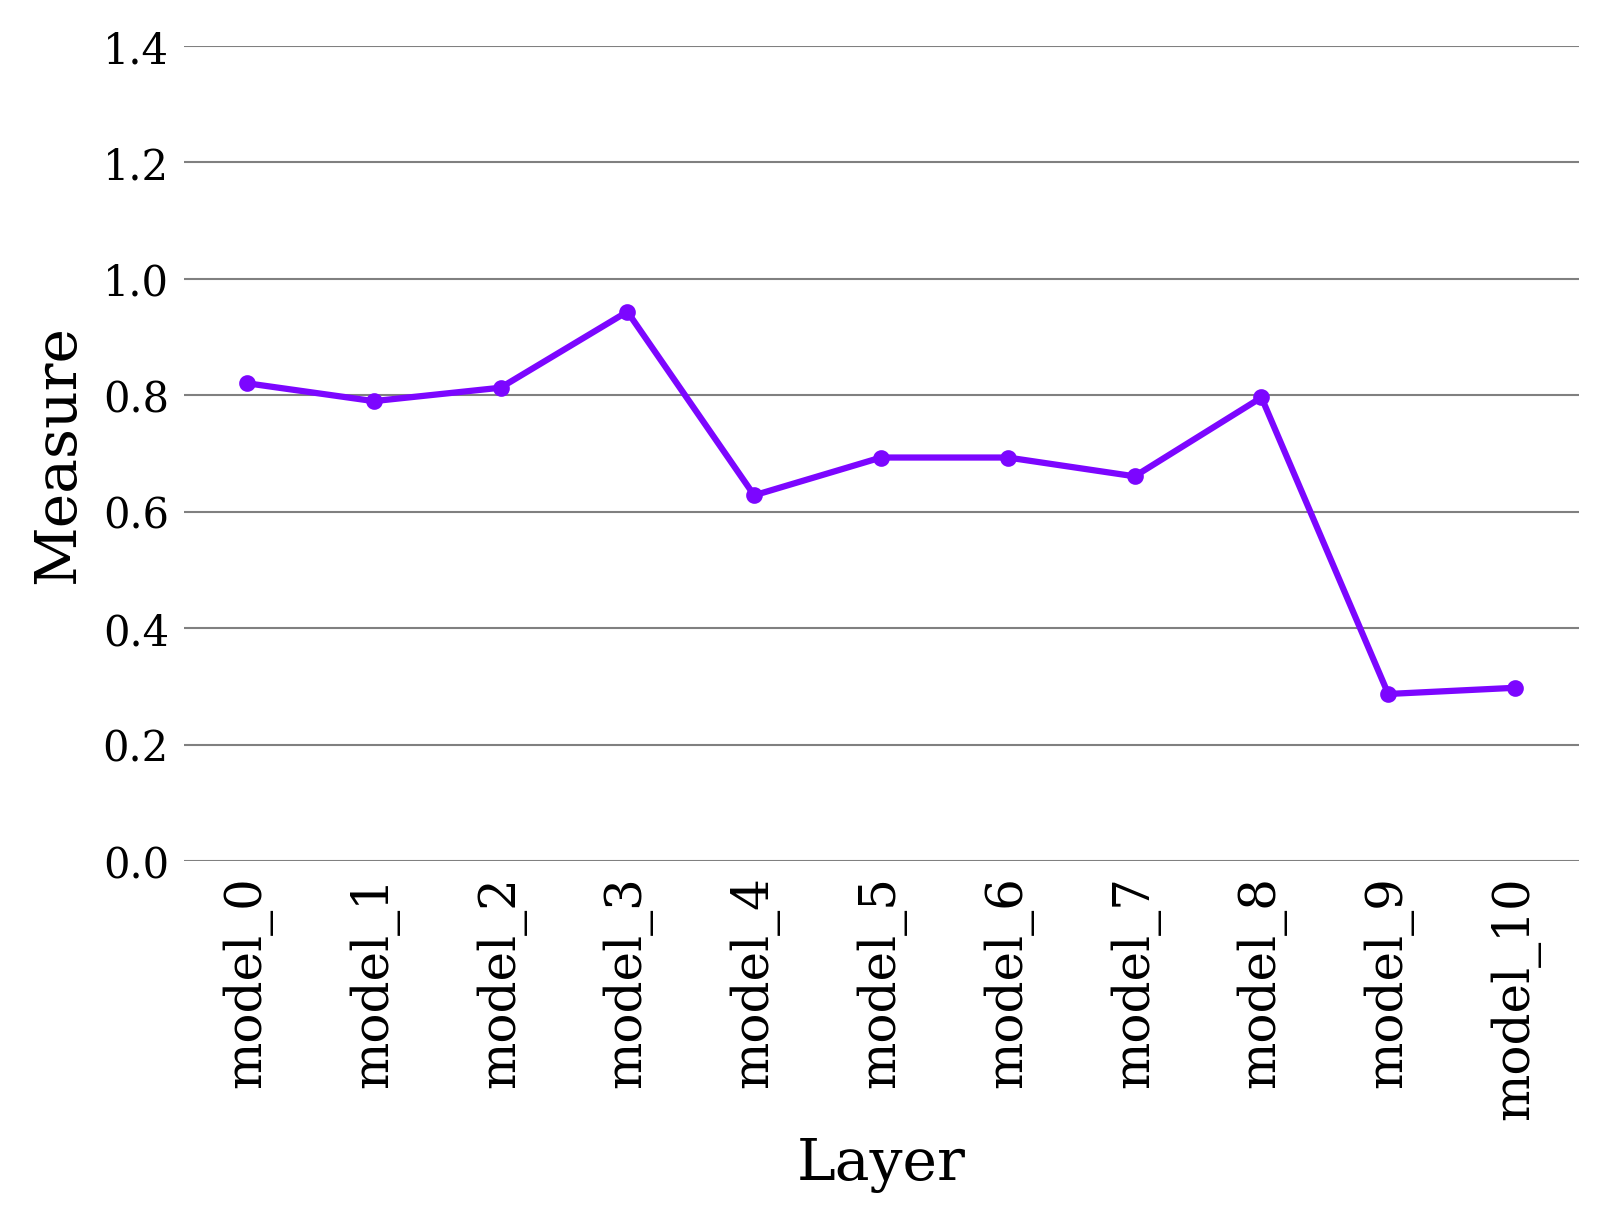

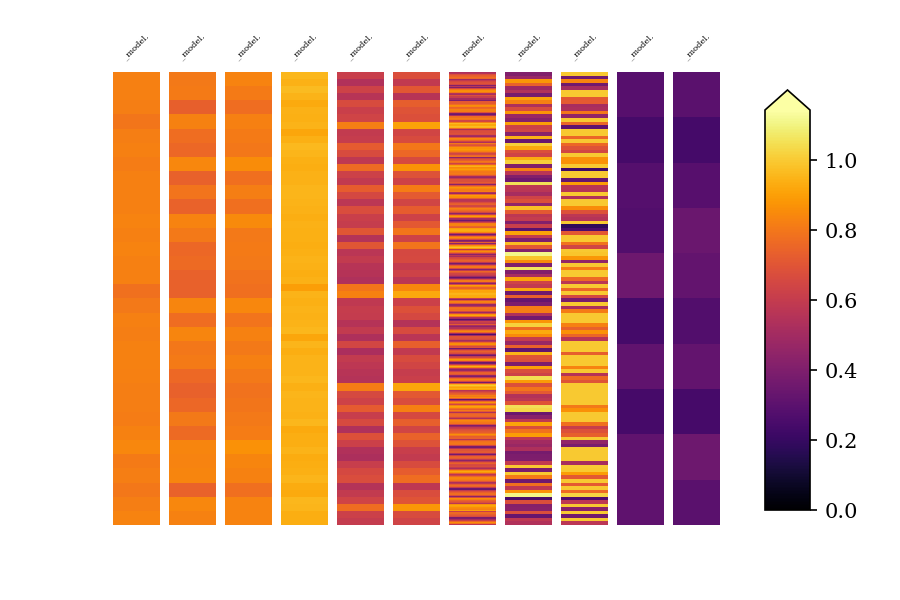

In [8]:



results=[measure_result]
plot_filepath=f"by_layers.png"
tm.visualization.plot_collapsing_layers_same_model(results, plot_filepath)
heatmap_filepath=path / f"heatmap.png"
tm.visualization.plot_heatmap(measure_result,heatmap_filepath)

from IPython.display import Image,display
display(Image(filename=plot_filepath))
display(Image(filename=heatmap_filepath))